In [51]:
from collections.abc import Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from input_data import lb3_time_opticaldensity_ph_glucose_protein_37

In [52]:
_TIMESTAMPS = len(lb3_time_opticaldensity_ph_glucose_protein_37) - 1

In [53]:
def plot_model_vs_experimental(
    params: np.ndarray,
    input_data: pd.DataFrame,
    temp_mult: float = 1.0,
    temp_label: str = "37C",
    title_prefix: str = 'DBN model simulation vs experimental data',
):
    optical_density_sim, ph_sim, glucose_sim, protein_sim = simulate(
        params, input_data, _TIMESTAMPS, temperature=temp_mult
    )
    simulation = {
        'OpticalDensity': optical_density_sim,
        'pH': ph_sim,
        'Glucose': glucose_sim,
        'Protein': protein_sim
    }
    
    plt.figure(figsize=(10, 6))
    time = input_data["Time"].values

    for key, series in simulation.items():
        plt.plot(time, series, label=f"{key} (model)")
        plt.plot(
            time, input_data[key].values, 'o--', label=f"{key} (experimental)"
        )

    plt.xlabel('Time (hours)')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f"{title_prefix} {temp_label}")
    plt.grid()
    plt.show()

In [54]:
def simulate(
    params: np.ndarray,
    input_data: pd.DataFrame,
    timestamps: int,
    temperature: float = 1.0,
    aeration: float = 1.0,
    stirring: float = 1.0,
) -> tuple[np.ndarray, ...]:
    optical_densitys, phs, glucoses, proteins = (
        [input_data["OpticalDensity"].iloc[0]],
        [input_data["pH"].iloc[0]],
        [input_data["Glucose"].iloc[0]],
        [input_data["Protein"].iloc[0]],
    )

    for _ in range(timestamps):
        optical_density, ph, glucose, protein = optical_densitys[-1], phs[-1], glucoses[-1], proteins[-1]
        environmental_effect = temperature * aeration * stirring

        optical_density_base = (
            params[0] * optical_density
            + params[1] * ph
            + params[2] * glucose
            + params[3] * protein
        )
        optical_density_next = optical_density_base * environmental_effect
        ph_next = params[4] + params[5] * ph - params[6] * optical_density_next
        glucose_next = glucose - params[7] * optical_density_next
        protein_next = protein + params[8] * optical_density_next - params[9] * protein

        optical_densitys.append(optical_density_next)
        phs.append(ph_next)
        glucoses.append(glucose_next)
        proteins.append(protein_next)
    
    return np.array(optical_densitys), np.array(phs), np.array(glucoses), np.array(proteins)

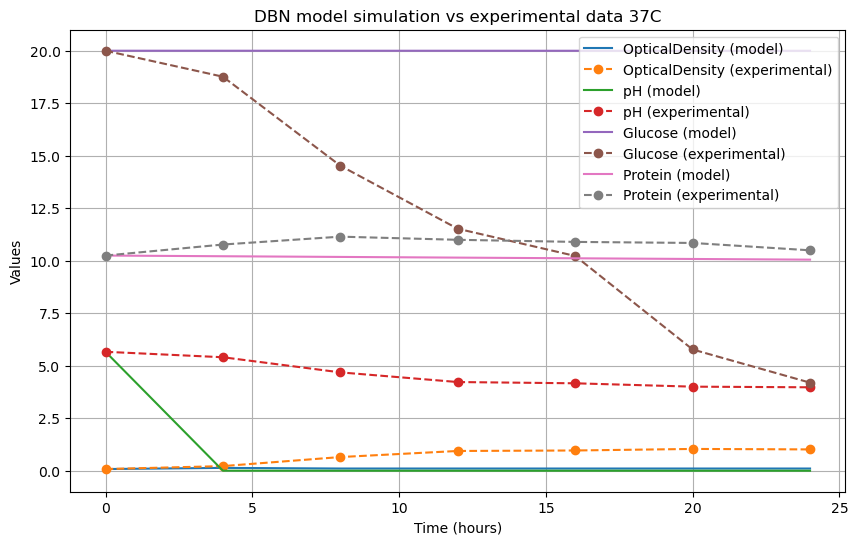

In [55]:
# Для простоти зовнішні впливи (Stirring, Aeration) поки не включаємо
params = np.random.rand(14) * 0.01

plot_model_vs_experimental(
    params,
    lb3_time_opticaldensity_ph_glucose_protein_37,
)

## Optimization part

In [56]:
def normalize(
    optical_density: np.ndarray,
    ph: np.ndarray,
    glucose: np.ndarray,
    protein: np.ndarray
) -> tuple[float]:
    _std = lambda x: float(np.std(x)) if float(np.std(x)) > 0 else 1.0
    return map(_std, (optical_density, ph, glucose, protein))


def make_loss(input_data: pd.DataFrame) -> Callable:
    optical_desnity_obs = input_data["OpticalDensity"].values
    ph_obs = input_data["pH"].values
    glucose_obs = input_data["Glucose"].values
    protein_obs = input_data["Protein"].values

    std_optical_density, std_ph, std_glucose, std_protein = normalize(
        optical_desnity_obs, ph_obs, glucose_obs, protein_obs
    )

    def loss(params: np.ndarray) -> float:
        optical_density_pred, ph_pred, glucose_pred, protein_pred = simulate(
            params, input_data, _TIMESTAMPS
        )
        rX  = (optical_density_pred  - optical_desnity_obs) / std_optical_density
        rpH = (ph_pred - ph_obs) / std_ph
        rG  = (glucose_pred  - glucose_obs) / std_glucose
        rB  = (protein_pred  - protein_obs) / std_protein
        error = float(np.sum(rX**2) + np.sum(rpH**2) + np.sum(rG**2) + np.sum(rB**2))
        return error
    return loss

In [57]:
loss_func = make_loss(lb3_time_opticaldensity_ph_glucose_protein_37)
optimal_params = minimize(
    loss_func,
    params,
    method='L-BFGS-B',
    options={'maxiter': 10_000}
)
print('Optimal params:', optimal_params.x)

Optimal params: [-3.15538673e+00 -1.44718400e+00 -6.07431333e-02  9.76404695e-01
  6.46256970e+00 -7.51513462e-02  2.06397732e+00  3.50808920e+00
 -1.16556772e+00 -9.29066844e-02  4.35932748e-03  2.32730960e-03
  1.50122942e-03  8.68137076e-03]


In [58]:
# def _temp_coeff_objective(
#     coeffs: np.ndarray,
#     nn_optimal_params: np.ndarray,
#     input_data: pd.DataFrame,
#     temp_labels: list[str],
#     target_final_optical_density: dict[str, float]
# ) -> float:
#     total_error = 0.0
#     for i, temp_label in enumerate(temp_labels):
#         coeff = coeffs[i]
#         X_pred, *_ = simulate(nn_optimal_params, input_data, len(input_data) - 1, temperature=coeff)
#         final_od = X_pred[-1]
#         target_od = target_final_optical_density[temp_label]
#         total_error += (final_od - target_od)**2
#     return total_error


# def optimize_temp_coefficients(
#     nn_optimal_params: np.ndarray,
#     input_data: pd.DataFrame,
#     target_final_optical_density: dict[str, float] = {"35C": 0.98477563, "40C": 0.947898, "45C": 0.8577189},
#     base_temp: str = "37C",
# ) -> dict[str, float]:
#     temp_labels = [t for t in target_final_optical_density.keys() if t != base_temp]
#     initial_coeffs = [0.5] * len(temp_labels)
    
#     result = minimize(
#         _temp_coeff_objective,
#         initial_coeffs,
#         args=(nn_optimal_params, input_data, temp_labels, target_final_optical_density),
#         method='L-BFGS-B',
#         bounds=[(0.1, 2.0)] * len(temp_labels)
#     )
    
#     coefficients = {
#         temp_label: result.x[i]
#         for i, temp_label in enumerate(temp_labels)
#     }
#     coefficients[base_temp] = 1.0
#     return coefficients


# optimized_temp_coeffs = optimize_temp_coefficients(
#     optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37
# )

# _TEMPERATURES = (
#     ("35C", optimized_temp_coeffs["35C"]),
#     ("37C", optimized_temp_coeffs["37C"]),
#     ("40C", optimized_temp_coeffs["40C"]),
#     ("45C", optimized_temp_coeffs["45C"]),
# )

In [59]:
_TEMPERATURES = (
    # ('35C', 0.976458),
    ('35C', 0.95),
    ('37C', 1.0),
    ('40C', 0.950491),
    ('45C', 0.814320)
)
_AERATION = (
    ("154mm²", 0.789030),
    ("517mm²", 0.793249), 
    ("2289mm²", 0.943460),
    ("3017mm²", 1.000000),
)
_STIRRING = (
    ('0rpm', 0.7894736842105263),
    ('50rpm', 1.0),
    ('100rpm', 0.8708133971291867),
    ('150rpm', 0.767464114832536)
)

In [103]:
optical_density_model_temp35, ph_temp_35, glucoses_temp_35, proteins_temp_35 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS, temperature=0.8, aeration=0.8, stirring=0.8
)
optical_density_model_temp37, ph_temp_37, glucoses_temp_37, proteins_temp_37 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS
)
optical_density_model_temp40, ph_temp_40, glucoses_temp_40, proteins_temp_40 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS, temperature=0.75, aeration=0.75, stirring=0.75
)
optical_density_model_temp45, ph_temp_45, glucoses_temp_45, proteins_temp_45 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS, temperature=0.7, aeration=0.7, stirring=0.7
)

In [104]:
# Single Parameter Set Summary:
#   temperature_label: 35C_adjusted
#   temperature_coefficient_continuous: 0.9932251164461745
#   temperature_coefficient_nominal35C: 0.95
#   aeration_coefficient_continuous: 0.9302504527730455
#   stirring_coefficient_continuous: 0.9071491377487604
#   aeration_discrete_coeff: 0.94346
#   aeration_discrete_label: 2289mm²
#   stirring_discrete_coeff: 0.8708133971291867

In [105]:
def plot_optical_density_multi_temp(
    input_data: pd.DataFrame,
    model_curves: dict[str, np.ndarray],
    title: str = 'DBN model simulation with optimized parameters (with temperature multiplier)'
):
    time = input_data['Time'].values
    plt.figure(figsize=(10, 6))

    for label, y in model_curves.items():
        plt.plot(time, y, label=f'OpticalDensity model ({label})', marker='o')
    
    plt.plot(
        time, input_data['OpticalDensity'].values, 'o--', label='OpticalDensity experimental'
    )
    plt.legend()
    plt.xlabel('Time (hours)')
    plt.ylabel('Optical Density')
    plt.title(title)
    plt.grid()
    plt.show()

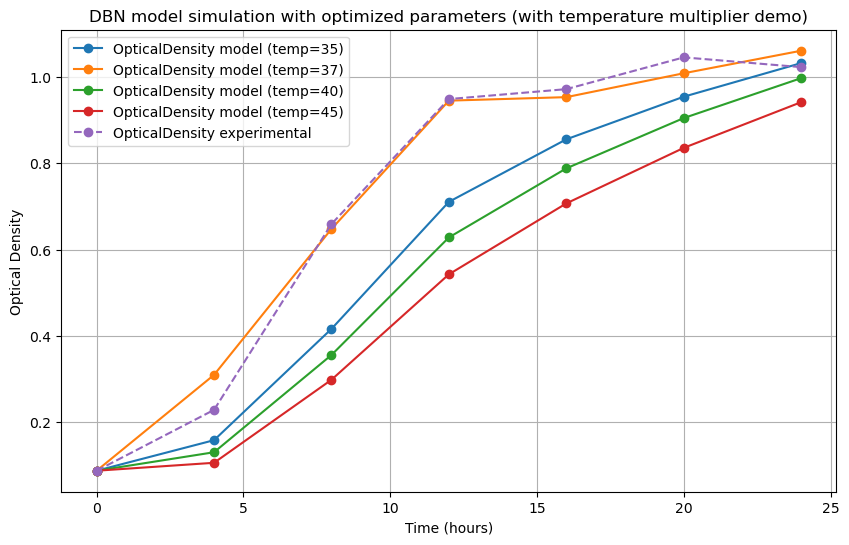

In [106]:
plot_optical_density_multi_temp(
    lb3_time_opticaldensity_ph_glucose_protein_37,
    {
        'temp=35': optical_density_model_temp35,
        'temp=37': optical_density_model_temp37,
        'temp=40': optical_density_model_temp40,
        'temp=45': optical_density_model_temp45,
    },
    title='DBN model simulation with optimized parameters (with temperature multiplier demo)'
)

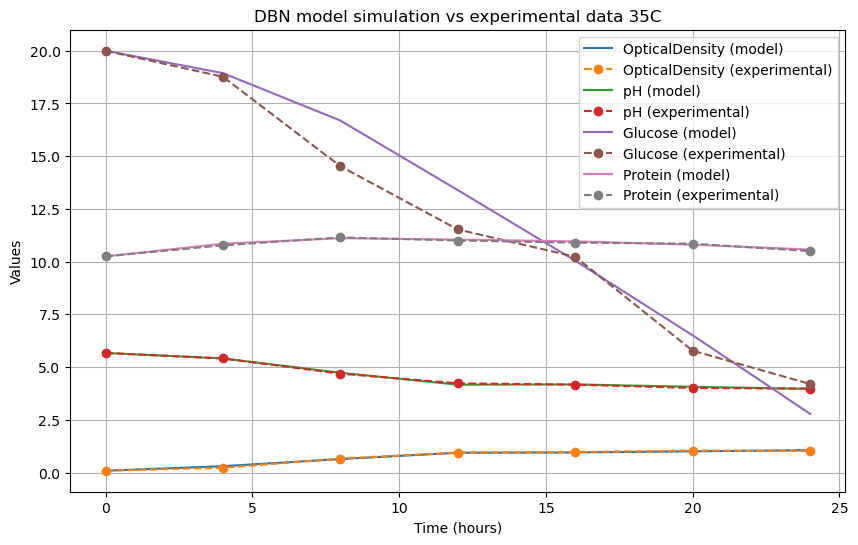

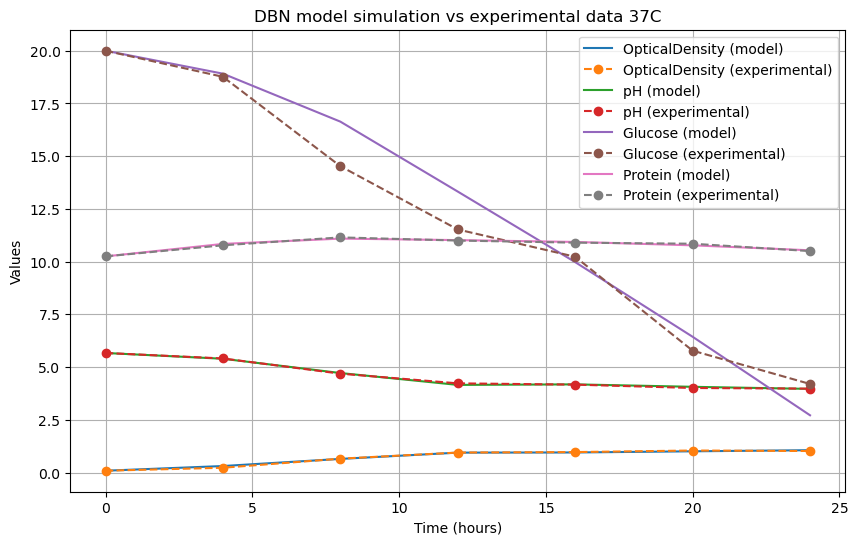

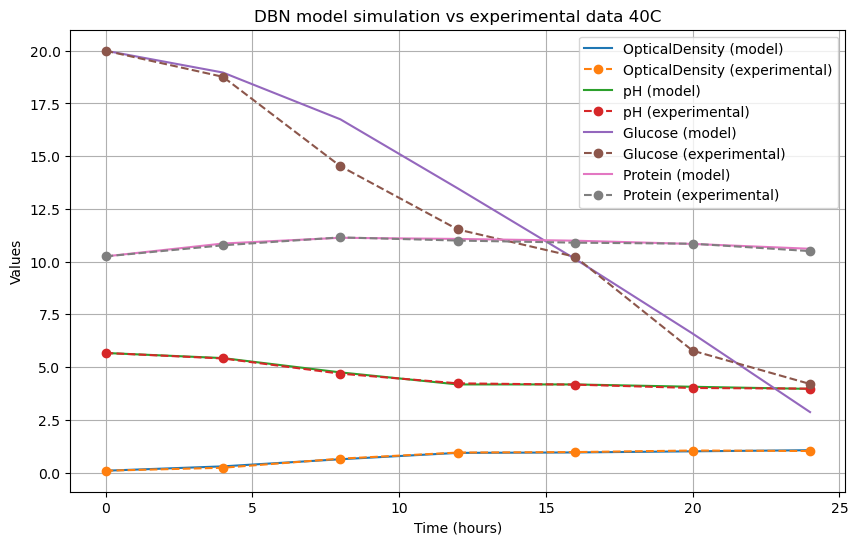

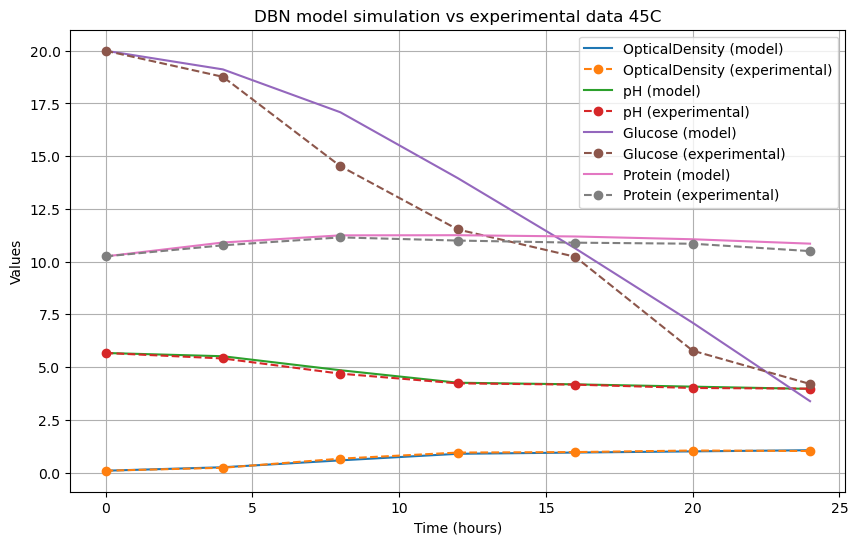

In [35]:
for label, temp_mult in _TEMPERATURES:
    plot_model_vs_experimental(
        optimal_params.x,
        lb3_time_opticaldensity_ph_glucose_protein_37,
        temp_mult=temp_mult,
        temp_label=label,
        title_prefix='DBN model simulation vs experimental data'
    )

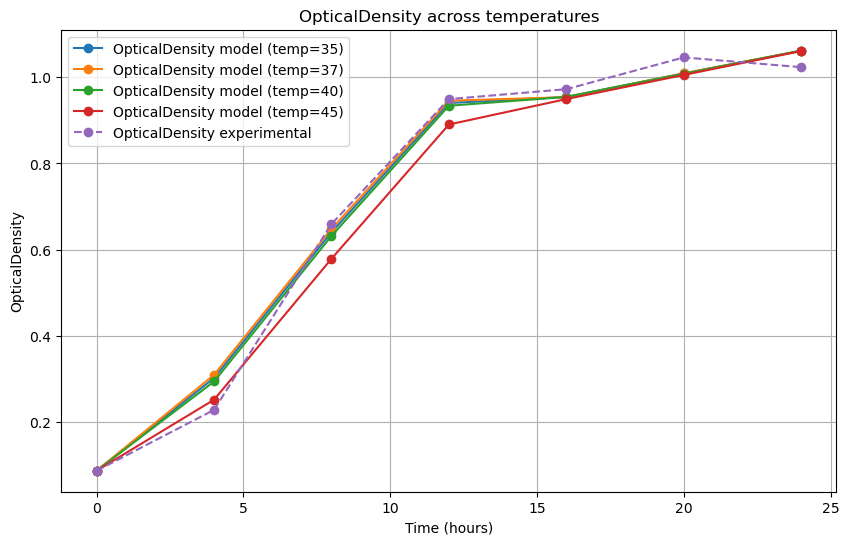

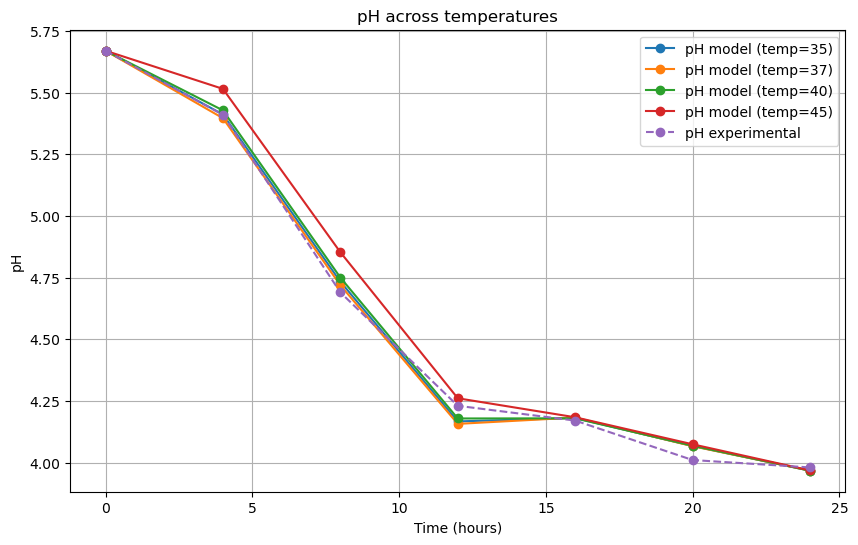

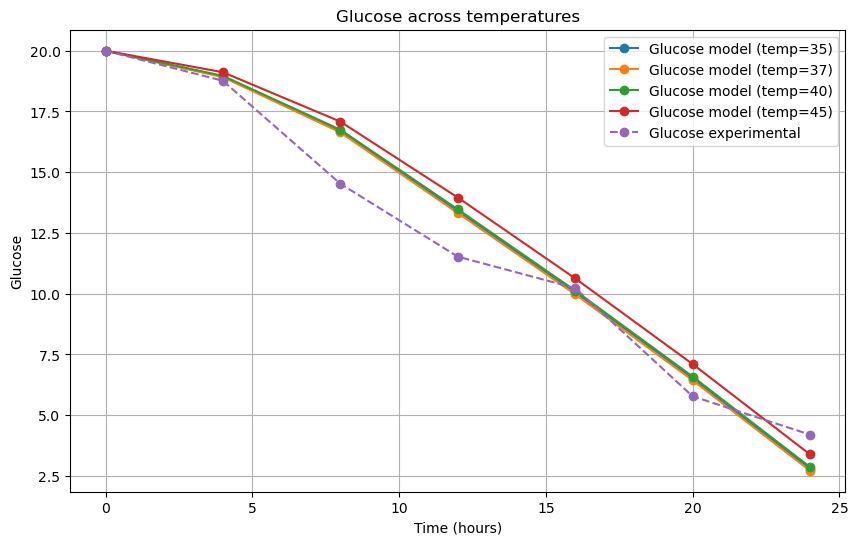

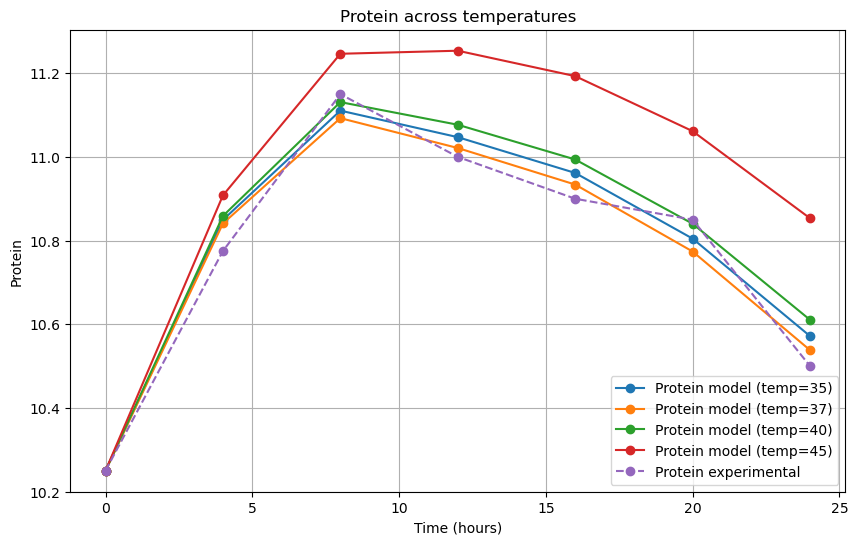

In [36]:
def plot_variable(
    input_data: pd.DataFrame,
    model_curves: dict[str, np.ndarray],
    var_label: str,
    title: str
):
    time = input_data["Time"].values
    plt.figure(figsize=(10, 6))
    
    for label, y in model_curves.items():
        plt.plot(time, y, marker="o", label=f"{var_label} model ({label})")
    
    plt.plot(time, input_data[var_label].values, "o--", label=f"{var_label} experimental")
    plt.xlabel("Time (hours)")
    plt.ylabel(var_label)
    plt.title(title or f"{var_label} across temperatures")
    plt.legend()
    plt.grid()
    plt.show()


data = {
    "OpticalDensity": {
        "temp=35": optical_density_model_temp35,
        "temp=37": optical_density_model_temp37,
        "temp=40": optical_density_model_temp40,
        "temp=45": optical_density_model_temp45,
    },
    "pH": {
        "temp=35": pH_model_temp35,
        "temp=37": pH_model_temp37,
        "temp=40": pH_model_temp40,
        "temp=45": pH_model_temp45,
    },
    "Glucose": {
        "temp=35": G_model_temp35,
        "temp=37": G_model_temp37,
        "temp=40": G_model_temp40,
        "temp=45": G_model_temp45,
    },
    "Protein": {
        "temp=35": B_model_temp35,
        "temp=37": B_model_temp37,
        "temp=40": B_model_temp40,
        "temp=45": B_model_temp45,
    },
}

for var_label, model_curves in data.items():
    plot_variable(
        lb3_time_opticaldensity_ph_glucose_protein_37,
        model_curves,
        var_label,
        title=f"{var_label} across temperatures"
    )

Per-step derived schedule (balanced sqrt split):
   t  Time  TargetOD_next    BaseOD  RequiredEnvEffect  AppliedAeration  \
0  0   0.0       0.217550  0.310078           0.701597         0.859374   
1  1   4.0       0.626525  0.749368           0.836071         0.938123   
2  2   8.0       0.901550  1.085195           0.830773         0.935146   
3  3  12.0       0.923400  1.133072           0.814953         0.926199   
4  4  16.0       0.993320  1.238992           0.801716         0.918647   
5  5  20.0       0.971850  1.323251           0.734441         0.879259   

   AppliedStirring  AchievedOD_next      OD_Error  
0         0.859374         0.217550  5.551115e-17  
1         0.938123         0.626525  0.000000e+00  
2         0.935146         0.901550 -1.110223e-16  
3         0.926199         0.923400  0.000000e+00  
4         0.918647         0.993320  0.000000e+00  
5         0.879259         0.971850  0.000000e+00  

Schedule Performance Metrics -> RMSE: 0.00000 | MAE: 0.00000

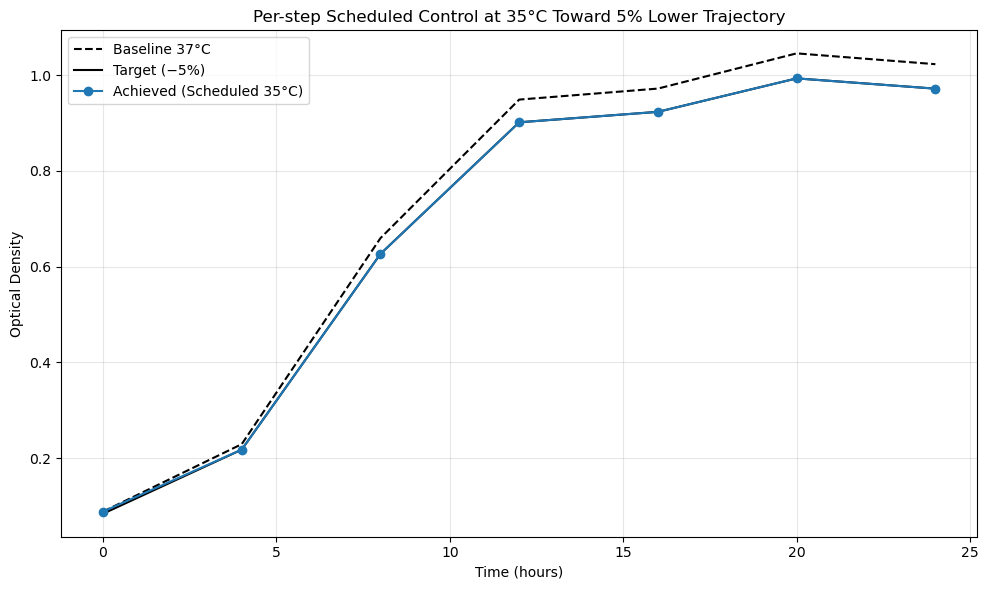

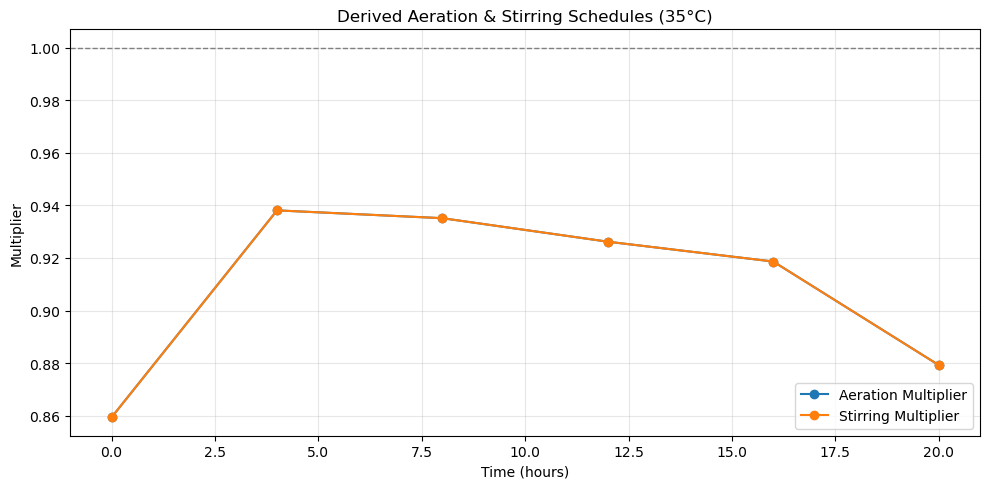


Rounded (feasible) schedule using nearest existing discrete multipliers:
   t  Time  AppliedAeration  NearestAerationDiscrete  AppliedStirring  \
0  0   0.0         0.859374                 0.793249         0.859374   
1  1   4.0         0.938123                 0.943460         0.938123   
2  2   8.0         0.935146                 0.943460         0.935146   
3  3  12.0         0.926199                 0.943460         0.926199   
4  4  16.0         0.918647                 0.943460         0.918647   
5  5  20.0         0.879259                 0.943460         0.879259   

   NearestStirringDiscrete  
0                 0.870813  
1                 1.000000  
2                 0.870813  
3                 0.870813  
4                 0.870813  
5                 0.870813  


In [73]:
# Derive per-time-step external parameter schedule at 35°C to reach ~5% lower OD than 37°C baseline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preconditions: optimal_params, baseline_37_optical_density, target_optical_density already defined in earlier cells.
# If not, redefine minimal baseline structures:
if 'baseline_37_optical_density' not in globals():
    baseline_37_optical_density = np.array([0.088, 0.229, 0.6595, 0.949, 0.972, 1.0456, 1.023], dtype=float)
    target_optical_density = baseline_37_optical_density * 0.95

# Select temperature coefficient for 35°C
TEMP_LABEL = '35C'
TEMP_COEFF_35 = dict(_TEMPERATURES)[TEMP_LABEL]

TIME = lb3_time_opticaldensity_ph_glucose_protein_37['Time'].values
N_STEPS = len(TIME) - 1  # transitions

# Helper: simulate with per-step aeration & stirring schedules (temperature fixed)
def simulate_with_schedule(
    params: np.ndarray,
    input_data: pd.DataFrame,
    temp_coeff: float,
    aeration_schedule: np.ndarray,
    stirring_schedule: np.ndarray,
) -> dict:
    assert len(aeration_schedule) == N_STEPS and len(stirring_schedule) == N_STEPS
    Xs = [input_data['OpticalDensity'].iloc[0]]
    pHs = [input_data['pH'].iloc[0]]
    Gs = [input_data['Glucose'].iloc[0]]
    Bs = [input_data['Protein'].iloc[0]]

    for t in range(N_STEPS):
        X, pH, G, B = Xs[-1], pHs[-1], Gs[-1], Bs[-1]
        # Base (pre-environment) growth component
        X_base = (
            params[0] * X +
            params[1] * pH +
            params[2] * G +
            params[3] * B
        )
        env_effect = temp_coeff * aeration_schedule[t] * stirring_schedule[t]
        X_next = X_base * env_effect
        pH_next = params[4] + params[5] * pH - params[6] * X_next
        G_next = G - params[7] * X_next
        B_next = B + params[8] * X_next - params[9] * B

        Xs.append(X_next)
        pHs.append(pH_next)
        Gs.append(G_next)
        Bs.append(B_next)
    return {
        'OpticalDensity': np.array(Xs),
        'pH': np.array(pHs),
        'Glucose': np.array(Gs),
        'Protein': np.array(Bs)
    }

# Derive required combined environmental effect schedule
# We build schedule sequentially so state propagation is respected

def derive_balanced_schedule(
    params: np.ndarray,
    input_data: pd.DataFrame,
    temp_coeff: float,
    target_od: np.ndarray,
    lower_bound: float = 0.6,
    upper_bound: float = 1.05,
    split: str = 'balanced',  # 'balanced' or 'fix_aeration' or 'fix_stirring'
    fixed_aeration: float = 1.0,
    fixed_stirring: float = 1.0,
) -> pd.DataFrame:
    if len(target_od) != len(input_data['Time']):
        raise ValueError('Target OD length mismatch with time axis.')

    # Initialize state tracking
    X = input_data['OpticalDensity'].iloc[0]
    pH = input_data['pH'].iloc[0]
    G = input_data['Glucose'].iloc[0]
    B = input_data['Protein'].iloc[0]

    rows = []
    for t in range(N_STEPS):
        # Base without environment
        X_base = (
            params[0] * X +
            params[1] * pH +
            params[2] * G +
            params[3] * B
        )
        desired_next = target_od[t+1]
        # Avoid division by zero
        if X_base <= 0:
            required_env_effect = 0.0
        else:
            required_env_effect = desired_next / X_base  # this equals temp * aer * stir
        # Product of aeration*stirring needed beyond temperature
        required_combined = required_env_effect / temp_coeff if temp_coeff > 0 else 0.0

        # Constrain to feasible window
        clamped_combined = float(np.clip(required_combined, lower_bound**2, upper_bound**2))

        # Factorization strategy
        if split == 'balanced':
            # sqrt split
            aer = stir = np.sqrt(clamped_combined)
        elif split == 'fix_aeration':
            aer = fixed_aeration
            stir = clamped_combined / aer if aer > 0 else lower_bound
        elif split == 'fix_stirring':
            stir = fixed_stirring
            aer = clamped_combined / stir if stir > 0 else lower_bound
        else:
            raise ValueError('Unknown split strategy.')

        # Clamp individual factors
        aer = float(np.clip(aer, lower_bound, upper_bound))
        stir = float(np.clip(stir, lower_bound, upper_bound))

        # Recompose actual env effect applied
        actual_env_effect = temp_coeff * aer * stir
        X_next = X_base * actual_env_effect
        pH_next = params[4] + params[5] * pH - params[6] * X_next
        G_next = G - params[7] * X_next
        B_next = B + params[8] * X_next - params[9] * B

        rows.append({
            't': t,
            'Time': input_data['Time'].iloc[t],
            'TargetOD_next': desired_next,
            'BaseOD': X_base,
            'RequiredEnvEffect': required_env_effect,
            'RequiredCombined(aer*stir)': required_combined,
            'AppliedAeration': aer,
            'AppliedStirring': stir,
            'AppliedEnvEffect': actual_env_effect,
            'AchievedOD_next': X_next,
            'OD_Error': X_next - desired_next
        })

        # Advance state
        X, pH, G, B = X_next, pH_next, G_next, B_next

    return pd.DataFrame(rows)

schedule_df = derive_balanced_schedule(
    optimal_params.x,
    lb3_time_opticaldensity_ph_glucose_protein_37,
    TEMP_COEFF_35,
    target_optical_density,
    lower_bound=0.6,
    upper_bound=1.05,
    split='balanced'
)

print('Per-step derived schedule (balanced sqrt split):')
print(schedule_df[['t','Time','TargetOD_next','BaseOD','RequiredEnvEffect','AppliedAeration','AppliedStirring','AchievedOD_next','OD_Error']])

# Compute metrics
rmse = float(np.sqrt(np.mean(schedule_df['OD_Error']**2)))
mae = float(np.mean(np.abs(schedule_df['OD_Error'])))
final_err = float(schedule_df['OD_Error'].iloc[-1])
print(f"\nSchedule Performance Metrics -> RMSE: {rmse:.5f} | MAE: {mae:.5f} | Final Error: {final_err:+.5f}")

# Plot comparison
achieved_od = np.concatenate([[lb3_time_opticaldensity_ph_glucose_protein_37['OpticalDensity'].iloc[0]], schedule_df['AchievedOD_next'].values])
plt.figure(figsize=(10,6))
plt.plot(TIME, baseline_37_optical_density, 'k--', label='Baseline 37°C')
plt.plot(TIME, target_optical_density, 'k', label='Target (−5%)')
plt.plot(TIME, achieved_od, 'o-', label='Achieved (Scheduled 35°C)')
plt.xlabel('Time (hours)')
plt.ylabel('Optical Density')
plt.title('Per-step Scheduled Control at 35°C Toward 5% Lower Trajectory')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot aeration & stirring schedules
plt.figure(figsize=(10,5))
plt.plot(schedule_df['Time'], schedule_df['AppliedAeration'], 'o-', label='Aeration Multiplier')
plt.plot(schedule_df['Time'], schedule_df['AppliedStirring'], 'o-', label='Stirring Multiplier')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Time (hours)')
plt.ylabel('Multiplier')
plt.title('Derived Aeration & Stirring Schedules (35°C)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Suggest mapping back to nearest discrete practical settings
# Prepare discrete sets (existing) for reference
AER_DISCRETE = [cfg[1] for cfg in _AERATION]
STIR_DISCRETE = [cfg[1] for cfg in _STIRRING]

def nearest(value: float, pool: list[float]) -> float:
    arr = np.array(pool)
    return float(arr[np.argmin(np.abs(arr - value))])

schedule_df['NearestAerationDiscrete'] = schedule_df['AppliedAeration'].apply(lambda v: nearest(v, AER_DISCRETE))
schedule_df['NearestStirringDiscrete'] = schedule_df['AppliedStirring'].apply(lambda v: nearest(v, STIR_DISCRETE))

print('\nRounded (feasible) schedule using nearest existing discrete multipliers:')
print(schedule_df[['t','Time','AppliedAeration','NearestAerationDiscrete','AppliedStirring','NearestStirringDiscrete']])

# NOTE: Using discrete rounding will change achieved OD; a secondary simulation could quantify that drift.


In [75]:
# Summarize per-step external parameter schedule (35°C) for reproducing the target OD plot
import json
import numpy as np
import pandas as pd

if 'schedule_df' not in globals():
    raise RuntimeError('schedule_df not found. Run the schedule derivation cell first.')

# Map discrete coefficient back to original labels
_aer_map = {coeff: label for label, coeff in _AERATION}
_stir_map = {coeff: label for label, coeff in _STIRRING}

def nearest_label(value: float, mapping: dict[float, str]) -> str:
    coeffs = np.array(list(mapping.keys()))
    nearest_coeff = float(coeffs[np.argmin(np.abs(coeffs - value))])
    return mapping[nearest_coeff]

# Build arrays (each row corresponds to transition Time[t] -> Time[t+1])
start_times = schedule_df['Time'].tolist()
end_times = lb3_time_opticaldensity_ph_glucose_protein_37['Time'].iloc[1:].tolist()
continuous_aer = schedule_df['AppliedAeration'].round(6).tolist()
continuous_stir = schedule_df['AppliedStirring'].round(6).tolist()
nearest_aer_coeff = schedule_df['NearestAerationDiscrete'].round(6).tolist()
nearest_stir_coeff = schedule_df['NearestStirringDiscrete'].round(6).tolist()
nearest_aer_labels = [nearest_label(v, _aer_map) for v in nearest_aer_coeff]
nearest_stir_labels = [nearest_label(v, _stir_map) for v in nearest_stir_coeff]

control_schedule = {
    'temperature_label': '35C',
    'temperature_coefficient': float(TEMP_COEFF_35),
    'time_intervals': [
        {
            'start_time': float(s),
            'end_time': float(e),
            'aeration_continuous': float(a),
            'stirring_continuous': float(st),
            'aeration_discrete_coeff': float(ad),
            'aeration_discrete_label': al,
            'stirring_discrete_coeff': float(sd),
            'stirring_discrete_label': sl,
        }
        for s, e, a, st, ad, al, sd, sl in zip(
            start_times,
            end_times,
            continuous_aer,
            continuous_stir,
            nearest_aer_coeff,
            nearest_aer_labels,
            nearest_stir_coeff,
            nearest_stir_labels,
        )
    ],
    'notes': 'Each entry corresponds to the control applied during the interval [start_time, end_time). Continuous multipliers are derived; discrete are nearest existing defined levels.'
}

print('=== CONTROL SCHEDULE (JSON) ===')
print(json.dumps(control_schedule, indent=2))

# Optional: DataFrame view for quick inspection
summary_df = pd.DataFrame([
    {
        'start': r['start_time'],
        'end': r['end_time'],
        'aer_cont': r['aeration_continuous'],
        'stir_cont': r['stirring_continuous'],
        'aer_disc_coeff': r['aeration_discrete_coeff'],
        'aer_disc_label': r['aeration_discrete_label'],
        'stir_disc_coeff': r['stirring_discrete_coeff'],
        'stir_disc_label': r['stirring_discrete_label'],
    }
    for r in control_schedule['time_intervals']
])
print('\nTabular summary:')
print(summary_df)


=== CONTROL SCHEDULE (JSON) ===
{
  "temperature_label": "35C",
  "temperature_coefficient": 0.95,
  "time_intervals": [
    {
      "start_time": 0.0,
      "end_time": 4.0,
      "aeration_continuous": 0.859374,
      "stirring_continuous": 0.859374,
      "aeration_discrete_coeff": 0.793249,
      "aeration_discrete_label": "517mm\u00b2",
      "stirring_discrete_coeff": 0.870813,
      "stirring_discrete_label": "100rpm"
    },
    {
      "start_time": 4.0,
      "end_time": 8.0,
      "aeration_continuous": 0.938123,
      "stirring_continuous": 0.938123,
      "aeration_discrete_coeff": 0.94346,
      "aeration_discrete_label": "2289mm\u00b2",
      "stirring_discrete_coeff": 1.0,
      "stirring_discrete_label": "50rpm"
    },
    {
      "start_time": 8.0,
      "end_time": 12.0,
      "aeration_continuous": 0.935146,
      "stirring_continuous": 0.935146,
      "aeration_discrete_coeff": 0.94346,
      "aeration_discrete_label": "2289mm\u00b2",
      "stirring_discrete_coeff"

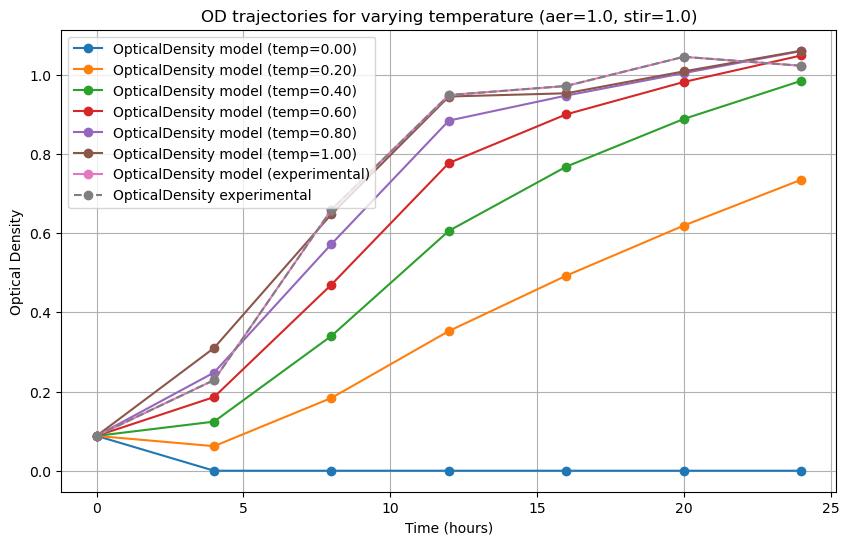

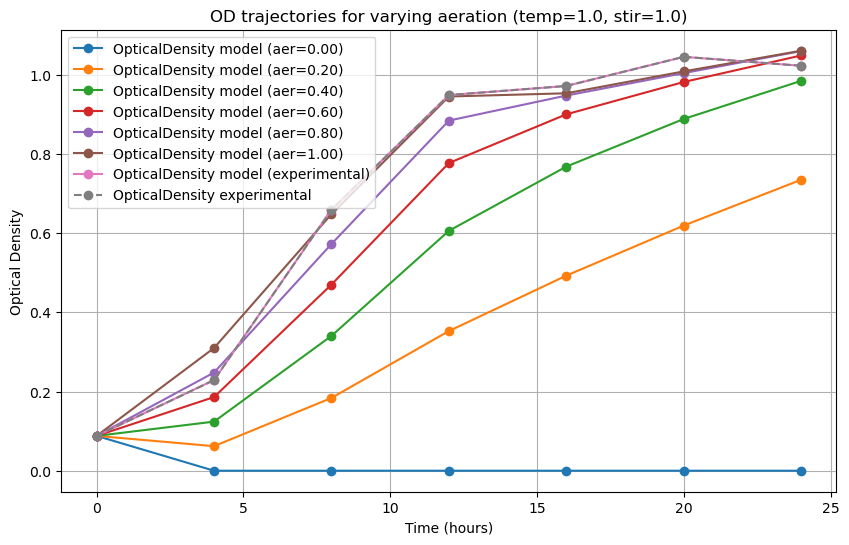

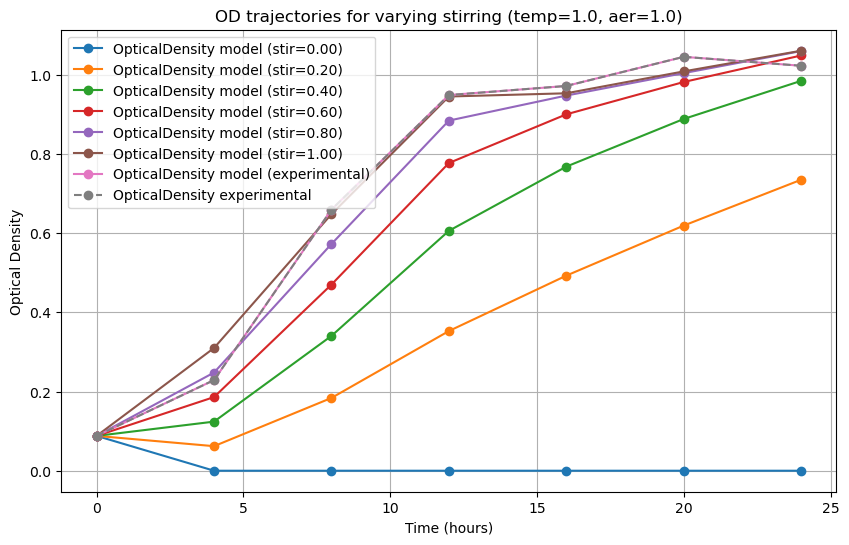

In [76]:
# Visualize OD trajectories for different combinations of temperature, aeration, and stirring
import numpy as np
import matplotlib.pyplot as plt

temp_range = np.linspace(0.0, 1.0, 6)
aer_range = np.linspace(0.0, 1.0, 6)
stir_range = np.linspace(0.0, 1.0, 6)

model_params = optimal_params.x
input_data = lb3_time_opticaldensity_ph_glucose_protein_37
TIMESTAMPS = len(input_data) - 1

def simulate_constant(params, input_data, temp_coeff, aer_coeff, stir_coeff):
    X, *_ = simulate(params, input_data, TIMESTAMPS, temperature=temp_coeff, aeration=aer_coeff, stirring=stir_coeff)
    return X

# 1. Vary temperature, fix aeration=1.0, stirring=1.0
plot_curves_temp = {}
for temp in temp_range:
    X = simulate_constant(model_params, input_data, temp, 1.0, 1.0)
    plot_curves_temp[f"temp={temp:.2f}"] = X
plot_curves_temp['experimental'] = input_data['OpticalDensity'].values
plot_optical_density_multi_temp(
    input_data,
    plot_curves_temp,
    title='OD trajectories for varying temperature (aer=1.0, stir=1.0)'
)

# 2. Vary aeration, fix temperature=1.0, stirring=1.0
plot_curves_aer = {}
for aer in aer_range:
    X = simulate_constant(model_params, input_data, 1.0, aer, 1.0)
    plot_curves_aer[f"aer={aer:.2f}"] = X
plot_curves_aer['experimental'] = input_data['OpticalDensity'].values
plot_optical_density_multi_temp(
    input_data,
    plot_curves_aer,
    title='OD trajectories for varying aeration (temp=1.0, stir=1.0)'
)

# 3. Vary stirring, fix temperature=1.0, aeration=1.0
plot_curves_stir = {}
for stir in stir_range:
    X = simulate_constant(model_params, input_data, 1.0, 1.0, stir)
    plot_curves_stir[f"stir={stir:.2f}"] = X
plot_curves_stir['experimental'] = input_data['OpticalDensity'].values
plot_optical_density_multi_temp(
    input_data,
    plot_curves_stir,
    title='OD trajectories for varying stirring (temp=1.0, aer=1.0)'
)

# You can further extend this to plot combinations, e.g., temp vs aeration, etc.

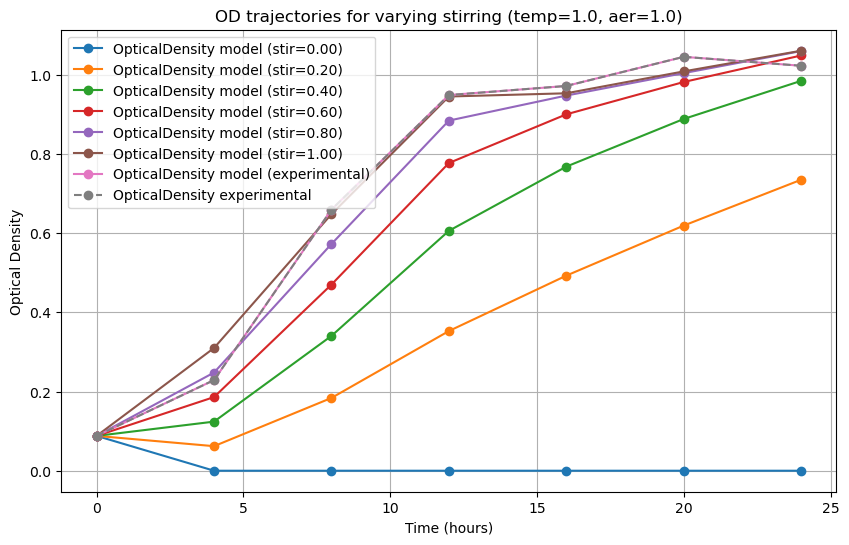

In [71]:
# Grid search over temperature, aeration, stirring in [0, 1] and visualize OD trajectories
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

temp_range = np.linspace(0.0, 1.0, 6)  # [0, 0.2, ..., 1.0]
aer_range = np.linspace(0.0, 1.0, 6)
stir_range = np.linspace(0.0, 1.0, 6)

model_params = optimal_params.x
input_data = lb3_time_opticaldensity_ph_glucose_protein_37
TIMESTAMPS = len(input_data) - 1

def simulate_constant(params, input_data, temp_coeff, aer_coeff, stir_coeff):
    X, *_ = simulate(params, input_data, TIMESTAMPS, temperature=temp_coeff, aeration=aer_coeff, stirring=stir_coeff)
    return X

# Store results for plotting
results = []
for temp in temp_range:
    for aer in aer_range:
        for stir in stir_range:
            X = simulate_constant(model_params, input_data, temp, aer, stir)
            results.append({
                'temperature': temp,
                'aeration': aer,
                'stirring': stir,
                'OD': X
            })

# Select a subset for visualization: e.g., all with temperature=1.0, aeration=1.0, varying stirring
plot_curves = {}
for r in results:
    if r['temperature'] == 1.0 and r['aeration'] == 1.0:
        label = f"stir={r['stirring']:.2f}"
        plot_curves[label] = r['OD']

# Add experimental curve for reference
plot_curves['experimental'] = input_data['OpticalDensity'].values

plot_optical_density_multi_temp(
    input_data,
    plot_curves,
    title='OD trajectories for varying stirring (temp=1.0, aer=1.0)'
)

# Optionally, plot for other fixed temp/aer values or create a heatmap of final OD vs parameters.

=== Optimized Constant Multipliers (Continuous Search) ===
Temperature Coefficient (base 35C 0.950000) -> 0.993226
Aeration Coefficient  -> 0.930474
Stirring Coefficient  -> 0.907379
Optimization Success: True, Iterations: 3, Function Evals: 20
RMSE: 0.041413 | MAE: 0.030723 | Final Error: +0.088799

--- Nearest Discrete Implementation ---
Aeration nearest coeff 0.943460 (label: 2289mm²)
Stirring nearest coeff 0.870813 (label: 100rpm)
RMSE (discrete): 0.041774 | MAE: 0.031914 | Final Error: +0.088523


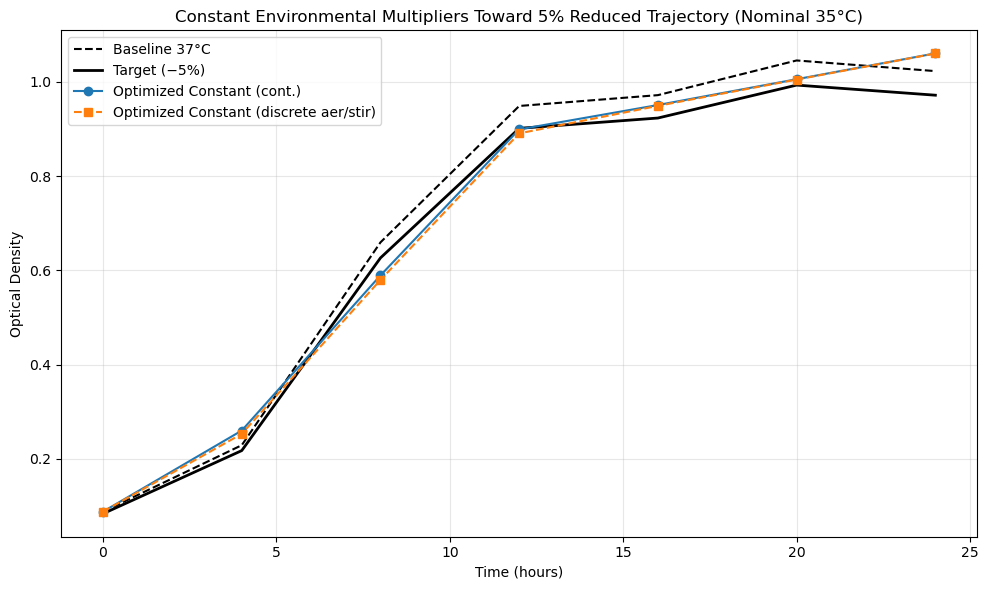


Trajectory Comparison (head):
   Time  Baseline37C  Target(-5%)  Optimized_Continuous  Optimized_Discrete  \
0   0.0       0.0880     0.083600              0.088000            0.088000   
1   4.0       0.2290     0.217550              0.260023            0.253028   
2   8.0       0.6595     0.626525              0.589457            0.579840   
3  12.0       0.9490     0.901550              0.899298            0.890849   
4  16.0       0.9720     0.923400              0.951020            0.949269   

   Resid_Continuous  Resid_Discrete  
0          0.004400        0.004400  
1          0.042473        0.035478  
2         -0.037068       -0.046685  
3         -0.002252       -0.010701  
4          0.027620        0.025869  

Single Parameter Set Summary:
  temperature_label: 35C_adjusted
  temperature_coefficient_continuous: 0.9932260552754903
  temperature_coefficient_nominal35C: 0.95
  aeration_coefficient_continuous: 0.9304740370691441
  stirring_coefficient_continuous: 0.9073791426

In [72]:
# Optimize a single constant (temperature, aeration, stirring) multiplier triple for ~5% lower OD at nominal 35°C
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Baseline (37°C) reference OD values provided by user (redefine explicitly for clarity)
baseline_37_optical_density = np.array([0.088, 0.229, 0.6595, 0.949, 0.972, 1.0456, 1.023], dtype=float)
TARGET_REDUCTION = 0.95  # 5% lower
target_optical_density = baseline_37_optical_density * TARGET_REDUCTION

# Time axis
_time = lb3_time_opticaldensity_ph_glucose_protein_37['Time'].values

# Helper using existing simulate() (constant multipliers across all steps)
def simulate_constant(params: np.ndarray, input_data: pd.DataFrame, temp_coeff: float, aer_coeff: float, stir_coeff: float) -> np.ndarray:
    X, *_ = simulate(params, input_data, len(input_data) - 1, temperature=temp_coeff, aeration=aer_coeff, stirring=stir_coeff)
    return X  # Optical Density trajectory

# Objective: minimize SSE between model OD (with constant multipliers) and 5% reduced target
# We'll allow temperature coefficient to vary slightly around the existing 35C coefficient to "explore additional parameters"
TEMP_35_BASE = dict(_TEMPERATURES)['35C']

# Bounds (can be adjusted): keep temperature near plausible range, aeration/stirring wider for exploration
bounds = [
    (max(0.7, TEMP_35_BASE * 0.8), min(1.1, TEMP_35_BASE * 1.1)),  # temperature coefficient
    (0.6, 1.1),  # aeration coefficient
    (0.6, 1.1),  # stirring coefficient
]

# Initial guess: (existing 35C temp coeff, geometric mean of aeration & stirring discrete max/min)
aer_discrete = np.array([a for _, a in _AERATION])
stir_discrete = np.array([s for _, s in _STIRRING])
init = [TEMP_35_BASE, float(aer_discrete.mean()), float(stir_discrete.mean())]

TARGET = target_optical_density

# Precompute mask (all points) & maybe weighting (optional uniform)
weights = np.ones_like(TARGET)

# Use optimal network params
model_params = optimal_params.x

def objective(x: np.ndarray) -> float:
    temp_c, aer_c, stir_c = x
    X_pred = simulate_constant(model_params, lb3_time_opticaldensity_ph_glucose_protein_37, temp_c, aer_c, stir_c)
    # Ensure same length
    if X_pred.shape[0] != TARGET.shape[0]:
        return 1e6
    residual = (X_pred - TARGET) * weights
    return float(np.sum(residual**2))

res = minimize(objective, init, method='L-BFGS-B', bounds=bounds, options={'maxiter': 500})
opt_temp, opt_aer, opt_stir = res.x

X_opt = simulate_constant(model_params, lb3_time_opticaldensity_ph_glucose_protein_37, opt_temp, opt_aer, opt_stir)

# Error metrics
residual = X_opt - TARGET
rmse = float(np.sqrt(np.mean(residual**2)))
mae = float(np.mean(np.abs(residual)))
final_err = float(residual[-1])

print('=== Optimized Constant Multipliers (Continuous Search) ===')
print(f"Temperature Coefficient (base 35C {TEMP_35_BASE:.6f}) -> {opt_temp:.6f}")
print(f"Aeration Coefficient  -> {opt_aer:.6f}")
print(f"Stirring Coefficient  -> {opt_stir:.6f}")
print(f"Optimization Success: {res.success}, Iterations: {res.nit}, Function Evals: {res.nfev}")
print(f"RMSE: {rmse:.6f} | MAE: {mae:.6f} | Final Error: {final_err:+.6f}")

# Map to nearest existing discrete levels (for practical implementation)
_aer_map = {coeff: label for label, coeff in _AERATION}
_stir_map = {coeff: label for label, coeff in _STIRRING}

def nearest_coeff(value: float, pool: np.ndarray) -> float:
    return float(pool[np.argmin(np.abs(pool - value))])

aer_nearest = nearest_coeff(opt_aer, aer_discrete)
stir_nearest = nearest_coeff(opt_stir, stir_discrete)

X_discrete = simulate_constant(model_params, lb3_time_opticaldensity_ph_glucose_protein_37, opt_temp, aer_nearest, stir_nearest)
residual_disc = X_discrete - TARGET
rmse_disc = float(np.sqrt(np.mean(residual_disc**2)))
mae_disc = float(np.mean(np.abs(residual_disc)))
final_err_disc = float(residual_disc[-1])

print('\n--- Nearest Discrete Implementation ---')
print(f"Aeration nearest coeff {aer_nearest:.6f} (label: {_aer_map[aer_nearest]})")
print(f"Stirring nearest coeff {stir_nearest:.6f} (label: {_stir_map[stir_nearest]})")
print(f"RMSE (discrete): {rmse_disc:.6f} | MAE: {mae_disc:.6f} | Final Error: {final_err_disc:+.6f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(_time, baseline_37_optical_density, 'k--', label='Baseline 37°C')
plt.plot(_time, TARGET, 'k', linewidth=2, label='Target (−5%)')
plt.plot(_time, X_opt, 'o-', label='Optimized Constant (cont.)')
plt.plot(_time, X_discrete, 's--', label='Optimized Constant (discrete aer/stir)')
plt.xlabel('Time (hours)')
plt.ylabel('Optical Density')
plt.title('Constant Environmental Multipliers Toward 5% Reduced Trajectory (Nominal 35°C)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Tabular comparison
comparison_df = pd.DataFrame({
    'Time': _time,
    'Baseline37C': baseline_37_optical_density,
    'Target(-5%)': TARGET,
    'Optimized_Continuous': X_opt,
    'Optimized_Discrete': X_discrete,
    'Resid_Continuous': residual,
    'Resid_Discrete': residual_disc,
})
print('\nTrajectory Comparison (head):')
print(comparison_df.head())

# Provide final single-parameter set summary structure
single_parameter_set = {
    'temperature_label': '35C_adjusted',
    'temperature_coefficient_continuous': float(opt_temp),
    'temperature_coefficient_nominal35C': float(TEMP_35_BASE),
    'aeration_coefficient_continuous': float(opt_aer),
    'stirring_coefficient_continuous': float(opt_stir),
    'aeration_discrete_coeff': float(aer_nearest),
    'aeration_discrete_label': _aer_map[aer_nearest],
    'stirring_discrete_coeff': float(stir_nearest),
    'stirring_discrete_label': _stir_map[stir_nearest],
    'metrics': {
        'continuous': {'RMSE': rmse, 'MAE': mae, 'FinalError': final_err},
        'discrete': {'RMSE': rmse_disc, 'MAE': mae_disc, 'FinalError': final_err_disc},
    },
    'notes': 'Single constant multipliers optimized via L-BFGS-B to approximate 5% reduced OD trajectory.'
}
print('\nSingle Parameter Set Summary:')
for k, v in single_parameter_set.items():
    if k != 'metrics':
        print(f"  {k}: {v}")
print('  metrics:')
for mcat, mdict in single_parameter_set['metrics'].items():
    print(f"    {mcat}: {mdict}")
